# SGA
This notebook demonstrates basic workflow on implementation of Simple Genetic Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
from core import *
from IPython.core.debugger import set_trace

# convenient jupyter notebook settings
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=np.nan)

Random initialization of bit strings of given length

In [2]:
def bit_initializer(population_size: int, individual_length: int) -> np.ndarray:
    return np.random.rand(population_size, individual_length) < 0.5
    
# class Initializer(InitializerBase):
#     def __init__(self):
#         super(Initializer, self).__init__()

#     def __call__(self, population_size: int, **kwargs) -> np.ndarray:
#         raise NotImplementedError

Objective function

In [3]:
def objective_fnc(individuals: np.ndarray) -> np.ndarray:
    return individuals.sum(-1)
    
# class ObjectiveFnc(ObjectiveFncBase):
#     def __init__(self):
#         super(ObjectiveFnc, self).__init__()
        
#     def __call__(self, individuals: np.ndarray) -> np.ndarray:
#         raise NotImplementedError

Fitness function

In [4]:
# def fitness_fnc(individuals: np.ndarray, objectives: np.ndarray) -> np.ndarray:
#     raise NotImplementedError
    
# class FitnessFnc(FitnessFncBase):
#     def __init__(self):
#         super(FitnessFnc, self).__init__()
    
#     def __call__(self, individuals: np.ndarray, objectives: np.ndarray) -> np.ndarray:
#         raise NotImplementedError

Early stopping criterion

In [5]:
def early_stopping(ga: GeneticAlgorithm):
    raise NotImplementedError

# class EarlyStopping(EarlyStoppingBase):
#     def __init__(self):
#         super(EarlyStopping, self).__init__()
        
#     def __call__(self, ga: GeneticAlgorithm) -> bool:
#         raise NotImplementedError

SGA operators as designed by Holland

In [6]:
class RouletteWheelSelection(OperatorBase):
    def __init__(self, whole_op: OperatorBase):
        super(RouletteWheelSelection, self).__init__(whole_op)
        
    def _operation(self, ga: GeneticAlgorithm, *input_populations: Population) -> Population:
        whole_pop = input_populations[0]

        chosen_index = np.random.choice(whole_pop.size, size=whole_pop.size, p=(whole_pop.fitnesses / whole_pop.fitnesses.sum()))
        
        return Population(whole_pop.individuals[chosen_index], ga)

In [7]:
class OnePointXover(OperatorBase):
    def __init__(self, parents_op: OperatorBase, prob: float = 0.7):
        super(OnePointXover, self).__init__(parents_op)
        
        self.prob = prob
        
    def _operation(self, ga: GeneticAlgorithm, *input_populations: Population) -> Population:
        parents = input_populations[0].individuals
        
        xover_index = np.arange(0, len(parents), 2)[np.random.rand(len(parents) // 2) < self.prob]
        xover_edges = (np.random.rand(len(xover_index)) * parents.shape[1]).astype(np.int)
        
        offspring = parents.copy()
        for x_i in range(len(xover_index)):
            p1_i , p2_i = xover_index[x_i], xover_index[x_i] + 1
            xover_edge = xover_edges[x_i]
            
            offspring[p1_i, xover_edge:] = parents[p2_i, xover_edge:]
            offspring[p2_i, xover_edge:] = parents[p1_i, xover_edge:]
        
        return Population(offspring, ga)

In [8]:
class BitFlipMutation(OperatorBase):
    def __init__(self, naturals_op: OperatorBase, individual_prob: float = 0.05, gene_prob: float = 0.05):
        super(BitFlipMutation, self).__init__(naturals_op)
        
        self.individual_prob = individual_prob
        self.gene_prob = gene_prob
        
    def _operation(self, ga: GeneticAlgorithm, *input_populations: Population) -> Population:
        naturals = input_populations[0].individuals
        
        mutation_index = np.arange(len(naturals))[np.random.rand(len(naturals)) < self.individual_prob]
        mutation_mask = np.random.rand(len(mutation_index), naturals.shape[1]) < self.gene_prob
        
        mutants = naturals.copy()
        for m_i in range(len(mutation_index)):
            i_i = mutation_index[m_i]
        
            mutants[i_i, mutation_mask[m_i]] = ~naturals[i_i, mutation_mask[m_i]]
        
        return Population(mutants, ga)

Callbacks for visual population tracking, fitness tracking

In [18]:
class PopulationVisualReport(CallbackBase):
    def __init__(self, ax: plt.Axes):
        super(PopulationVisualReport, self).__init__()
        
        self._ax = ax
        
    def __call__(self, ga: GeneticAlgorithm) -> None:
        self._ax.clear()
        self._ax.axis('off')
        self._ax.imshow(np.swapaxes(ga.capture(-1).individuals, 0, 1))

class ObjectiveReport(CallbackBase):
    def __init__(self, ax: plt.Axes):
        super(ObjectiveReport, self).__init__()
        
        self._ax = ax
    
    def __call__(self, ga: GeneticAlgorithm) -> None:
        self._ax.clear()
        self._ax.plot(np.max(ga.objectives_history, axis=-1))
        self._ax.set_title(
            'Current best fitness: {:.6f}'.format(np.max(ga.objectives_history[-1]))
        )
        
class GAStatus(CallbackBase):
    def __init__(self, fig: plt.Figure):
        super(GAStatus, self).__init__()

        self._fig = fig

    def __call__(self, ga: GeneticAlgorithm) -> None:
        self._fig.canvas.set_window_title('Current generation: {}'.format(ga.current_generation))
        self._fig.canvas.draw()

<IPython.core.display.Javascript object>


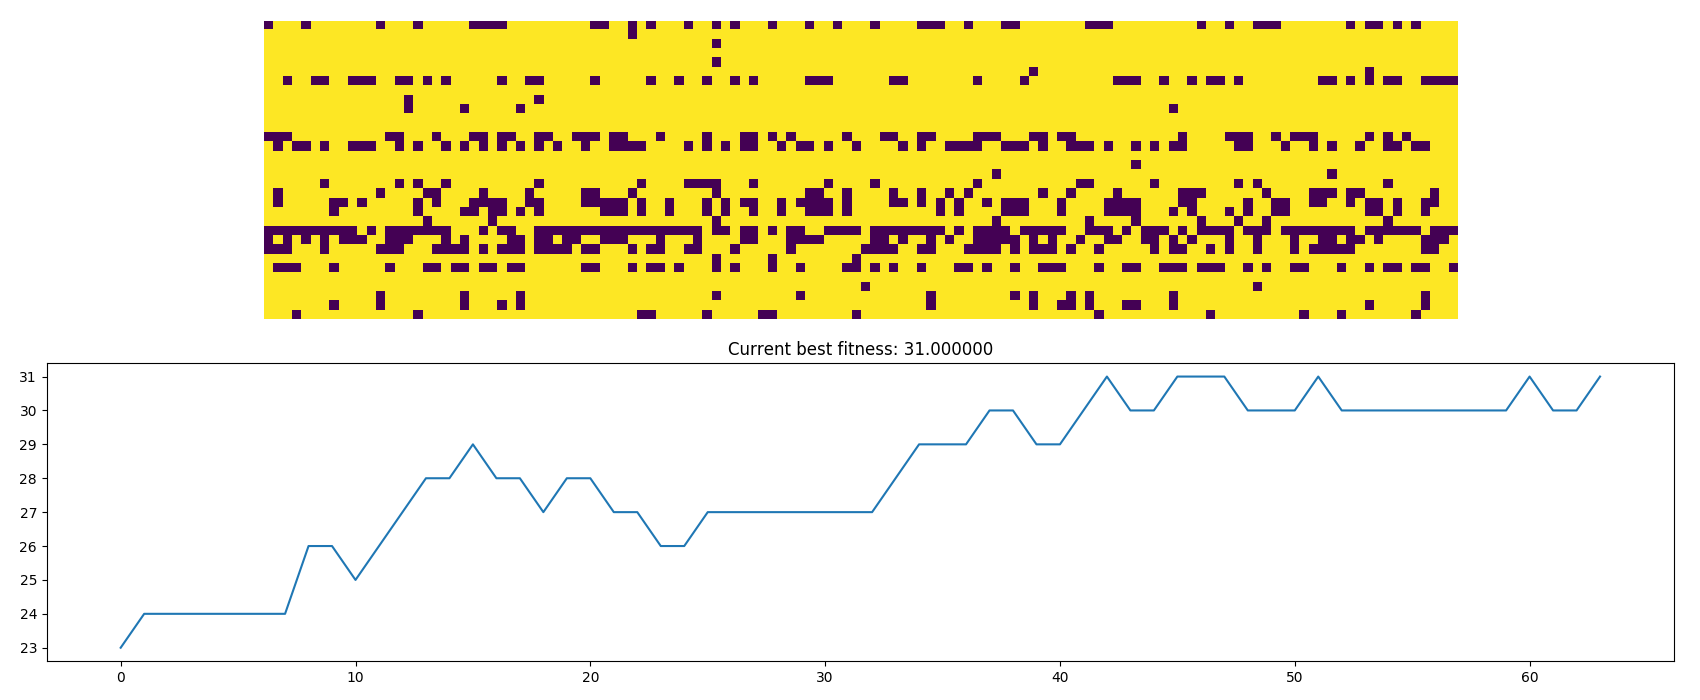

In [19]:
%matplotlib notebook

fig, ax = plt.subplots(2, 1, figsize=(17,7))
fig.tight_layout()

pop_report = PopulationVisualReport(ax[0])
obj_report = ObjectiveReport(ax[1])
ga_status = GAStatus(fig)

In [21]:
graph = OperatorGraph()

selection = RouletteWheelSelection(graph.init_op)
xover = OnePointXover(selection)
mutation = BitFlipMutation(xover)

ga = GeneticAlgorithm(
    initializer = bit_initializer,
    operator_graph = graph,
    objective_fnc = objective_fnc,
    fitness_fnc = None,
    callbacks = [ga_status, pop_report, obj_report]
)

In [26]:
result, fitnesses, objectives = ga.run(
    population_size = 128,
    generation_cap = 64,
    individual_length = 32
)